## 2.決定木学習とは


決定木学習は 決定木 と呼ばれる 木構造のグラフ を作る機械学習手法です。機械学習の分野では学習手法も単に「決定木」と呼ばれます。

分類にも回帰にも使え、分類の場合3クラス以上の多値分類が可能です。ここでは基本となる分類のみを扱います。

決定木とは
決定木は、属性 と 値 の組｛属性1：値1，属性2：値2, 属性3：値3,…，属性n：値n｝によって表現されたデータを、条件分岐を繰り返すことであるクラスに割り当てることができる木構造のグラフです。

以下の例は会場の気温という属性の値によって、開催と中止のクラスに割り当てるグラフです。「会場の気温という属性の値は35以上かどうか」という条件分岐1回による決定木による分類が行えます。例えば36度がこの決定木にインプットされれば、中止というアウトプット（判断）ができます。

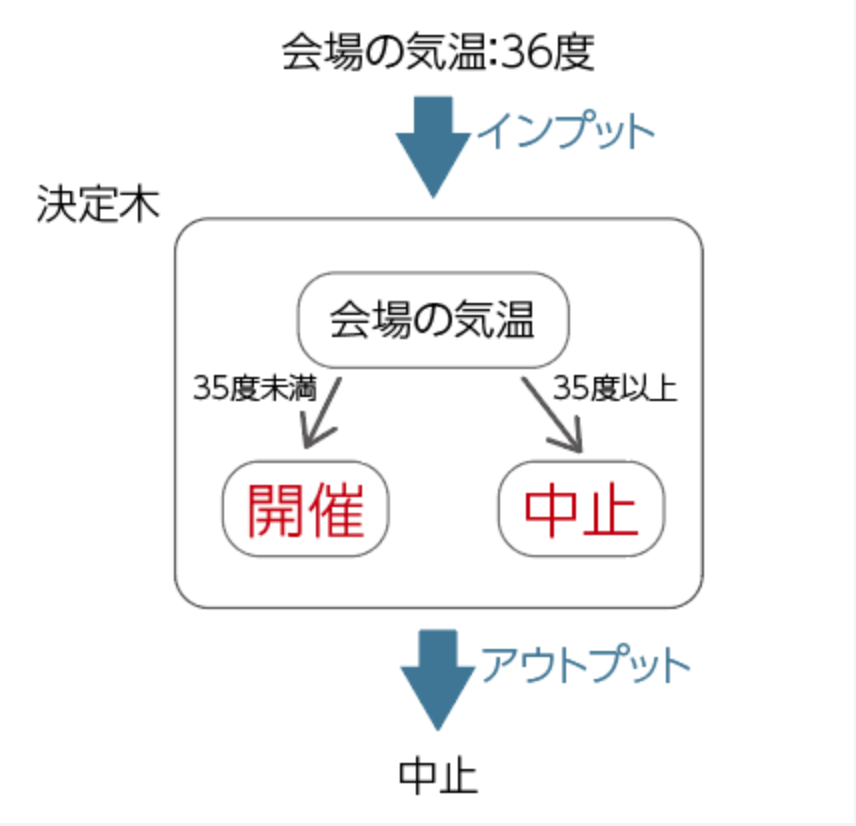

なお、「属性と値」は機械学習の分野では「特徴量の名前と特徴量の値」のことです。これ以降は単に特徴量という呼びます。

各種用語
もう少し複雑な例で決定木で重要な用語を確認します。特徴量が「雨量」「屋内かどうか」「風の強さ」の3種類で、イベントの開催か中止かを分類する場合で考えてみます。訓練データを学習することで、以下のような決定木が作れます。

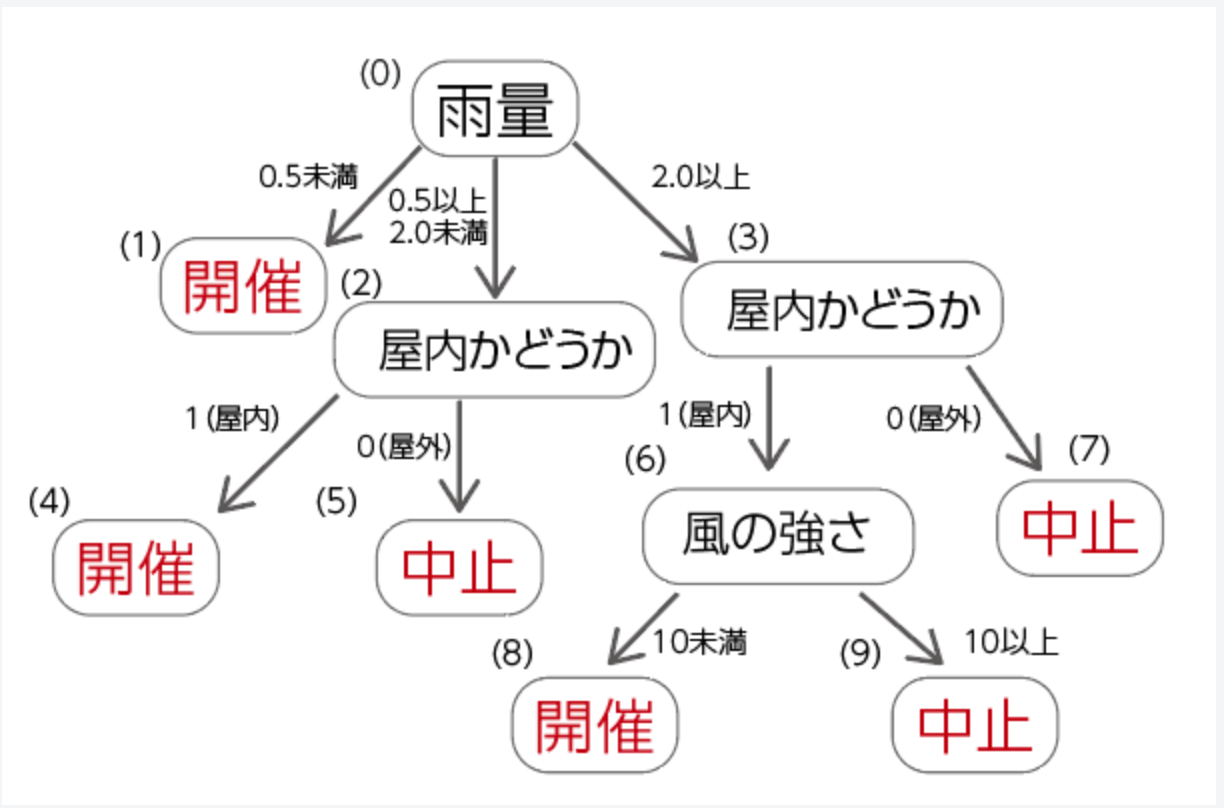

丸で囲われたひとつひとつを ノード と呼びます。ノードには親子関係を考えることができ、例えば(0)のノードは(1)(2)(3)のノードの 親ノード と呼びます。逆に、(1)(2)(3)のノードは(0)のノードの 子ノード と呼びます。

一番上の(0)は 根ノード 、 末端の(1)(4)(5)(7)(8)(9)のような分類結果を表すノードは 葉ノード と呼びます。

条件分岐の矢印は エッジ と呼びます。あるノードから根ノードまでのエッジの数が 深さ です。(3)の深さは1、(6)の深さは2、(9)の深さは3という風になります。この決定木の最大の深さは3です。

これは(0)に対して(1)(2)(3)の3つのノードが分かれている多岐分岐の決定木ですが、機械学習では2つにしか分かれないものが一般的です。学習時の複雑さを減らすためです。

どう決定木を作るか
決定木の学習には様々なやり方が存在しますが、その中のある方法についてスクラッチを行いながら見ていきます。

学習方法やハイパーパラメータ、訓練データ次第で作られる決定木は異なってきます。

推定を考える
以下の場合、イベントは開催されるでしょうか。決定木を使って判断してください。

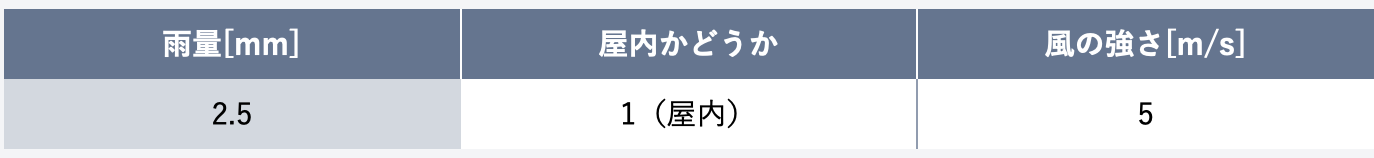

答えは「開催」です。以下の赤線の順でたどっていきます。

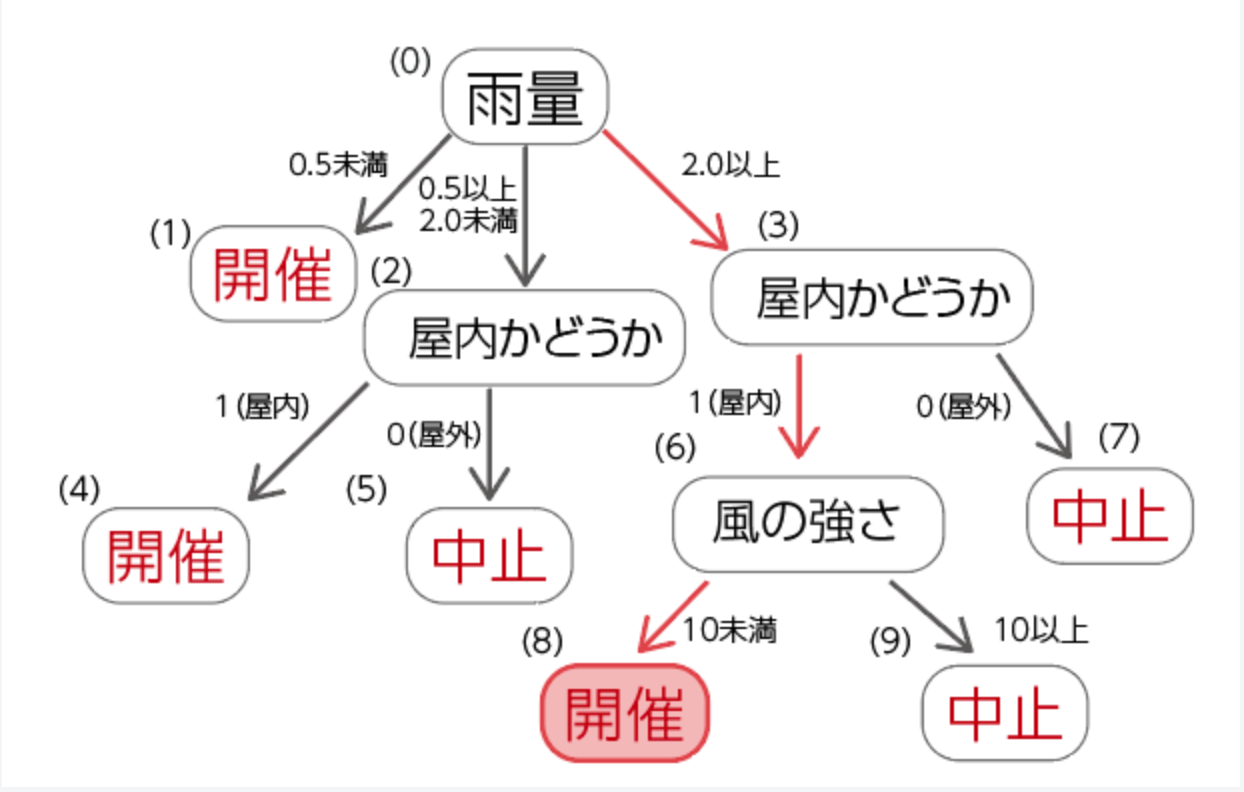

これが決定木による推定の操作になります。

扱える特徴量
決定木は理論上は量的変数だけでなく、カテゴリ変数も扱えます。しかし、scikit-learnの実装では量的変数のみに対応していますので、スクラッチ実装もそのように作成します。上記の例ですと「会場の種類」で「屋内と屋外」ですとカテゴリ変数ですが、「屋内かどうか」で「0と1」と量的変数にすることで扱えるようにしています。

## 3.決定木スクラッチ


分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

決定木の学習には何回まで条件分岐を繰り返すかを表す （最大の）深さ というハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。

学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されている CART法 をベースとした実装を行います。この方法では学習の複雑さを減らすために、 分岐は2つに分かれるのみ になります。

以下に雛形を用意してあります。このScratchDecesionTreeClassifierDepth1クラスにコードを書き加えていってください。

《雛形》

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
iris = load_iris()

from sklearn.preprocessing import StandardScaler

In [51]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        pass
        return

分割の条件を学習で求める
学習によって、ノードをどういった条件で分割すると、うまく分けられるかということを求めます。

うまく分けられていることを判定するためにノードに対してジニ不純度と情報利得という値を計算します。

#### 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード 
t
 に対するジニ不純度 
I
(
t
)
 は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。


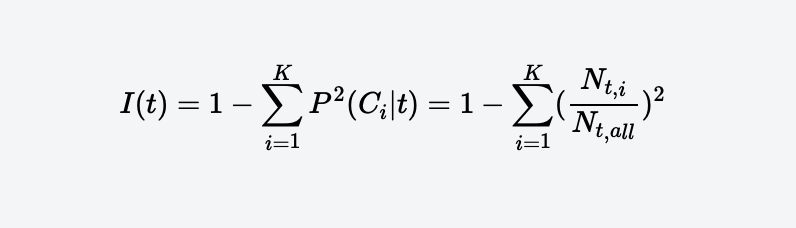

t
 : ノードのインデックス

i
 : クラスのインデックス

K
 : クラスの数

C
i
 : i番目のクラス

P
(
C
i
|
t
)
 :　t番目のノードにおける
C
i
の割合

N
t
,
i
 : t番目のノードのi番目のクラスに属するサンプル数

N
t
,
a
l
l
 : t番目のノードのサンプルの総数

まずは簡単な例を作り、手計算と関数の結果を比較してください。

《例》

クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500  
クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667  
クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480  
クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000  

In [52]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#y = y[:,np.newaxis]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [53]:
X_train.shape,y_train.shape

((30, 2), (30,))

In [54]:
idx_0 = np.where(y_train==0)
idx_1 = np.where(y_train==1)

In [55]:
X_train[idx_0].shape[0]

15

In [56]:
X_train[idx_0].shape[0]/X_train.shape[0]

0.5

In [57]:
x_0 =  ((X_train[idx_0].shape[0])/(X_train.shape[0]))**2
x_1 = ((X_train[idx_1].shape[0])/(X_train.shape[0]))**2
ai = 1-(x_0+x_1)
ai

0.5

In [58]:
def info(X,y):
    idx_0 = np.where(y==0)

    idx_1 = np.where(y==1)

    X0 = (X[idx_0].shape[0]/(X.shape[0]))**2
    X1 = (X[idx_1].shape[0]/(X.shape[0]))**2

    ai = 1-(X0+X1)
    #print(ai)
    return ai

In [59]:
info(X_train,y_train)

0.5

#### 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 
I
(
t
)
 を計算する関数を呼び出して使います。情報利得
I
G
は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。


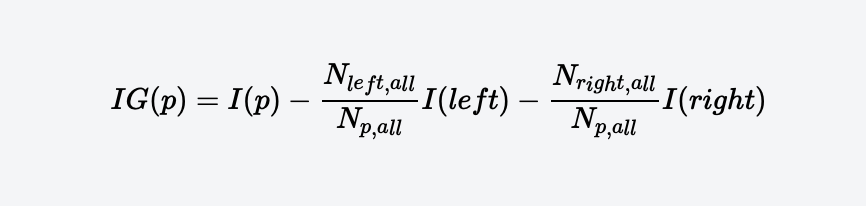


p
 : 親ノードを示すインデックス

l
e
f
t
 : 左側のノードを示すインデックス

r
i
g
h
t
 : 右側のノードを示すインデックス

まずは簡単な例を作り、手計算と関数の結果を比較してください。

《例》

左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143


In [60]:
node_0 = np.where(X_train[:,0]>=0.5)
node_1 = np.where(X_train[:,0]<0.5)
node_0,node_1

((array([ 7,  8, 12, 16, 20, 21, 22]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 17, 18, 19, 23,
         24, 25, 26, 27, 28, 29]),))

In [61]:
info(X_train[node_0],y_train[node_0])

0.48979591836734704

In [62]:
info(X_train[node_1],y_train[node_1])

0.499054820415879

In [63]:
ig = ai - (((X_train[node_0].shape[0]/X_train.shape[0])*info(X_train[node_0],y_train[node_0]))- ((X_train[node_1].shape[0]/X_train.shape[0])*info(X_train[node_1],y_train[node_1])))
ig

0.7683229813664596

#### 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。

《組み合わせの取り方》

全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。

他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。

《補足》

問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 
I
(
p
)
 は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

In [64]:
threshold = np.sort(X_train[:,0])

In [65]:
info(X_train[node_0],y_train[node_0])

0.48979591836734704

In [66]:
# if not node_1[0]:
#     print("a")
# else:
#     print("b")

In [67]:
node_1[0]

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 13, 14, 15, 17, 18, 19, 23,
       24, 25, 26, 27, 28, 29])

In [68]:
node_list=np.zeros(len(threshold))
threshold_list=np.zeros(len(threshold))
for x,i in enumerate(threshold):
    node_0 = np.where(X_train[:,0]>=i)
    node_1 = np.where(X_train[:,0]<i)
    if len(node_1[0]) == 0:
        threshold_list[x]+=i
        pass
    else:
        #print(node_0,node_1)
        ig = ai - (((X_train[node_0].shape[0]/X_train.shape[0])*info(X_train[node_0],y_train[node_0]))- ((X_train[node_1].shape[0]/X_train.shape[0])*info(X_train[node_1],y_train[node_1])))
        node_list[x]+=ig
        threshold_list[x]+=i
zip_list = zip(node_list,threshold_list)
threshold_list
list(zip_list)

[(0.0, -6.6797),
 (0.017241379310344862, -4.1013),
 (0.06666666666666665, -3.5944),
 (0.09506172839506172, -3.1625),
 (0.1192307692307692, -3.1108),
 (0.14266666666666666, -3.0603),
 (0.19166666666666654, -2.9452),
 (0.2316770186335404, -2.9362),
 (0.2613636363636363, -2.5677),
 (0.29894179894179895, -2.353),
 (0.33333333333333337, -2.234),
 (0.36602870813397126, -1.4621),
 (0.4, -1.281),
 (0.4330316742081448, -0.73535),
 (0.4666666666666667, -0.65259),
 (0.5, -0.61251),
 (0.5333333333333333, -0.60216),
 (0.5669683257918552, -0.57242),
 (0.6018518518518519, -0.44699),
 (0.6390749601275918, -0.12243),
 (0.6699999999999999, 0.057313),
 (0.701058201058201, 0.10645),
 (0.7386363636363638, 0.35084),
 (0.7683229813664596, 0.50214),
 (0.8, 0.56421),
 (0.836, 0.58619),
 (0.8807692307692307, 0.59912),
 (0.9049382716049383, 0.6017),
 (0.9642857142857143, 0.96765),
 (0.9827586206896551, 1.1319)]

#### 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。

入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [69]:
node_tes_0 = np.where(X_test[:,0]>=-6.6797)
node_tes_1 = np.where(X_test[:,0]<-6.6797)


In [70]:
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        self.y_hat = np.where(X[:,0]>=self.threshold,self.yl,self.yr)
        return self.y_hat


### 4.検証


#### 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [71]:
y = iris.target[:100]
X = iris.data[:100,:2]

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=71)
sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.fit_transform(X_test)

In [72]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [73]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装
    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=True,max_depth=1):
        self.max_depth = max_depth
        self.depth = 1
        self.left =None
        self.right=None
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    def ai(self,X,y):
        idx_0 = np.where(y==0)
        idx_1 = np.where(y==1)
        X0 = (X[idx_0].shape[0]/(X.shape[0]))**2
        X1 = (X[idx_1].shape[0]/(X.shape[0]))**2

        ai = 1-(X0+X1)
        print(ai)
        return ai    
    
    def ig(self,X,y):
        threshold = np.sort(X[:,0])
        node_list=np.zeros(len(threshold))
        self.threshold_list=np.zeros(len(threshold))
        for x,i in enumerate(threshold):
            node_0 = np.where(X[:,0]>=i)
            node_1 = np.where(X[:,0]<i)
            if len(node_1[0]) == 0:
                self.threshold_list[x]+=i
                pass
            else:
                #print(node_0,node_1)
                left = info(X[node_0],y[node_0])
                print(left)
                right = info(X[node_1],y[node_1])
                print("center",right)
                ig = self.gini - (X[node_0].shape[0]*left /X.shape[0]) - (X[node_1].shape[0]*right /X.shape[0])
                node_list[x]+=ig
                self.threshold_list[x]+=i
        self.zip_list = zip(node_list,self.threshold_list)
        print(node_list,self.threshold_list)
        return list(max(self.zip_list))
    

        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
        self.gini = self.ai(X,y)
        y_hat = self.ig(X,y)
        self.threshold = y_hat[1]
        self.node_0 = np.where(X[:,0]>=self.threshold)
        self.node_1 = np.where(X[:,0]<self.threshold)
        print(y[self.node_1])
        
        
        if 0 in y[self.node_0]  and 1 in y[self.node_0]:
            if 0 in y[self.node_1]:
                self.yl = 1
                self.yr= 0
            else:
                self.yl = 0
                self.yr = 1
        else:
            if 0 in y[self.node_0]:
                self.yl = 0
                self.yr= 1
            else:
                self.yl = 1
                self.yr = 0
               
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.threshold)

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        self.y_hat = np.where(X[:,0]>=self.threshold,self.yl,self.yr)
        return self.y_hat


In [74]:
sdc = ScratchDecesionTreeClassifierDepth1()
sdc.fit(X,y)
y_sdc = sdc.predict(X_test)
y_sdc

0.5
0.49967126890203817
center 0.0
0.5
center 0.5
0.4996347699050402
center 0.4444444444444444
0.4984567901234568
center 0.375
0.49632653061224496
center 0.31999999999999984
0.4982698961937716
center 0.4444444444444444
0.4995408631772268
center 0.48979591836734704
0.498046875
center 0.46875
0.49947970863683666
center 0.49382716049382713
0.5
center 0.5
0.4994054696789536
center 0.49586776859504145
0.5
center 0.5
0.4993141289437586
center 0.4970414201183432
0.5
center 0.5
0.4992
center 0.49777777777777776
0.5
center 0.5
0.499054820415879
center 0.4982698961937716
0.49586776859504145
center 0.49382716049382713
0.4988662131519275
center 0.4986149584487536
0.4949999999999999
center 0.4949999999999999
0.48753462603878117
center 0.48979591836734704
0.47530864197530853
center 0.48347107438016523
0.45674740484429055
center 0.4763705103969753
0.46875
center 0.48611111111111105
0.48
center 0.4927999999999999
0.4591836734693877
center 0.48816568047337283
0.47337278106508873
center 0.49382716049382

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1])

In [75]:
sdc.threshold

-0.12243

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [77]:
accuracy_score(y_sdc,y_test)

0.7

In [78]:
precision_score(y_sdc,y_test)

0.8

In [79]:
recall_score(y_sdc,y_test)

0.6666666666666666

In [80]:
f1_score(y_sdc,y_test)

0.7272727272727272

In [81]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
y_dtc = dtc.predict(X_test)
y_dtc

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

In [82]:
accuracy_score(y_dtc,y_test)

0.8

In [83]:
precision_score(y_dtc,y_test)

0.8

In [84]:
recall_score(y_dtc,y_test)

0.8

In [85]:
f1_score(y_dtc,y_test)

0.8000000000000002

#### 【問題6】決定領域の可視化
決定領域を可視化してください。


In [86]:
 def scat(X,y,model):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[y==0][:,0],X[y==0][:,1],label="0")
    plt.scatter(X[y==1][:,0],X[y==1][:,1],label="1")

    
    plt.legend()
    X0_min,X0_max = X[:,0].min(),X[:,0].max()
    X1_min,X1_max = X[:,1].min(),X[:,1].max()
    XX0,XX1 = np.meshgrid(np.linspace(X0_min,X0_max),np.linspace(X1_min,X1_max))
    grid = np.c_[XX0.ravel(),XX1.ravel()]

    probs = model.predict(grid).reshape(XX0.shape)

    plt.xlim(X0_min,X0_max)
    plt.ylim(X1_min,X1_max)
    plt.contour(XX0,XX1,probs,[0.5],linewidths=2)
    

[-6.6797 -4.353 ]
None
[-6.52027959 -4.353     ]
None
[-6.36085918 -4.353     ]
None
[-6.20143878 -4.353     ]
None
[-6.04201837 -4.353     ]
None
[-5.88259796 -4.353     ]
None
[-5.72317755 -4.353     ]
None
[-5.56375714 -4.353     ]
None
[-5.40433673 -4.353     ]
None
[-5.24491633 -4.353     ]
None
[-5.08549592 -4.353     ]
None
[-4.92607551 -4.353     ]
None
[-4.7666551 -4.353    ]
None
[-4.60723469 -4.353     ]
None
[-4.44781429 -4.353     ]
None
[-4.28839388 -4.353     ]
None
[-4.12897347 -4.353     ]
None
[-3.96955306 -4.353     ]
None
[-3.81013265 -4.353     ]
None
[-3.65071224 -4.353     ]
None
[-3.49129184 -4.353     ]
None
[-3.33187143 -4.353     ]
None
[-3.17245102 -4.353     ]
None
[-3.01303061 -4.353     ]
None
[-2.8536102 -4.353    ]
None
[-2.6941898 -4.353    ]
None
[-2.53476939 -4.353     ]
None
[-2.37534898 -4.353     ]
None
[-2.21592857 -4.353     ]
None
[-2.05650816 -4.353     ]
None
[-1.89708776 -4.353     ]
None
[-1.73766735 -4.353     ]
None
[-1.57824694 -4.353   

[-5.72317755 -0.26414286]
None
[-5.56375714 -0.26414286]
None
[-5.40433673 -0.26414286]
None
[-5.24491633 -0.26414286]
None
[-5.08549592 -0.26414286]
None
[-4.92607551 -0.26414286]
None
[-4.7666551  -0.26414286]
None
[-4.60723469 -0.26414286]
None
[-4.44781429 -0.26414286]
None
[-4.28839388 -0.26414286]
None
[-4.12897347 -0.26414286]
None
[-3.96955306 -0.26414286]
None
[-3.81013265 -0.26414286]
None
[-3.65071224 -0.26414286]
None
[-3.49129184 -0.26414286]
None
[-3.33187143 -0.26414286]
None
[-3.17245102 -0.26414286]
None
[-3.01303061 -0.26414286]
None
[-2.8536102  -0.26414286]
None
[-2.6941898  -0.26414286]
None
[-2.53476939 -0.26414286]
None
[-2.37534898 -0.26414286]
None
[-2.21592857 -0.26414286]
None
[-2.05650816 -0.26414286]
None
[-1.89708776 -0.26414286]
None
[-1.73766735 -0.26414286]
None
[-1.57824694 -0.26414286]
None
[-1.41882653 -0.26414286]
None
[-1.25940612 -0.26414286]
None
[-1.09998571 -0.26414286]
None
[-0.94056531 -0.26414286]
None
[-0.7811449  -0.26414286]
None
[-0.6217

None
[-5.72317755  3.82471429]
None
[-5.56375714  3.82471429]
None
[-5.40433673  3.82471429]
None
[-5.24491633  3.82471429]
None
[-5.08549592  3.82471429]
None
[-4.92607551  3.82471429]
None
[-4.7666551   3.82471429]
None
[-4.60723469  3.82471429]
None
[-4.44781429  3.82471429]
None
[-4.28839388  3.82471429]
None
[-4.12897347  3.82471429]
None
[-3.96955306  3.82471429]
None
[-3.81013265  3.82471429]
None
[-3.65071224  3.82471429]
None
[-3.49129184  3.82471429]
None
[-3.33187143  3.82471429]
None
[-3.17245102  3.82471429]
None
[-3.01303061  3.82471429]
None
[-2.8536102   3.82471429]
None
[-2.6941898   3.82471429]
None
[-2.53476939  3.82471429]
None
[-2.37534898  3.82471429]
None
[-2.21592857  3.82471429]
None
[-2.05650816  3.82471429]
None
[-1.89708776  3.82471429]
None
[-1.73766735  3.82471429]
None
[-1.57824694  3.82471429]
None
[-1.41882653  3.82471429]
None
[-1.25940612  3.82471429]
None
[-1.09998571  3.82471429]
None
[-0.94056531  3.82471429]
None
[-0.7811449   3.82471429]
None
[-0

[-0.7811449   7.91357143]
None
[-0.62172449  7.91357143]
None
[-0.46230408  7.91357143]
None
[-0.30288367  7.91357143]
None
[-0.14346327  7.91357143]
None
[0.01595714 7.91357143]
None
[0.17537755 7.91357143]
None
[0.33479796 7.91357143]
None
[0.49421837 7.91357143]
None
[0.65363878 7.91357143]
None
[0.81305918 7.91357143]
None
[0.97247959 7.91357143]
None
[1.1319     7.91357143]
None
[-6.6797      8.32245714]
None
[-6.52027959  8.32245714]
None
[-6.36085918  8.32245714]
None
[-6.20143878  8.32245714]
None
[-6.04201837  8.32245714]
None
[-5.88259796  8.32245714]
None
[-5.72317755  8.32245714]
None
[-5.56375714  8.32245714]
None
[-5.40433673  8.32245714]
None
[-5.24491633  8.32245714]
None
[-5.08549592  8.32245714]
None
[-4.92607551  8.32245714]
None
[-4.7666551   8.32245714]
None
[-4.60723469  8.32245714]
None
[-4.44781429  8.32245714]
None
[-4.28839388  8.32245714]
None
[-4.12897347  8.32245714]
None
[-3.96955306  8.32245714]
None
[-3.81013265  8.32245714]
None
[-3.65071224  8.32245714

None
[-5.88259796 12.00242857]
None
[-5.72317755 12.00242857]
None
[-5.56375714 12.00242857]
None
[-5.40433673 12.00242857]
None
[-5.24491633 12.00242857]
None
[-5.08549592 12.00242857]
None
[-4.92607551 12.00242857]
None
[-4.7666551  12.00242857]
None
[-4.60723469 12.00242857]
None
[-4.44781429 12.00242857]
None
[-4.28839388 12.00242857]
None
[-4.12897347 12.00242857]
None
[-3.96955306 12.00242857]
None
[-3.81013265 12.00242857]
None
[-3.65071224 12.00242857]
None
[-3.49129184 12.00242857]
None
[-3.33187143 12.00242857]
None
[-3.17245102 12.00242857]
None
[-3.01303061 12.00242857]
None
[-2.8536102  12.00242857]
None
[-2.6941898  12.00242857]
None
[-2.53476939 12.00242857]
None
[-2.37534898 12.00242857]
None
[-2.21592857 12.00242857]
None
[-2.05650816 12.00242857]
None
[-1.89708776 12.00242857]
None
[-1.73766735 12.00242857]
None
[-1.57824694 12.00242857]
None
[-1.41882653 12.00242857]
None
[-1.25940612 12.00242857]
None
[-1.09998571 12.00242857]
None
[-0.94056531 12.00242857]
None
[-0

AttributeError: 'list' object has no attribute 'reshape'

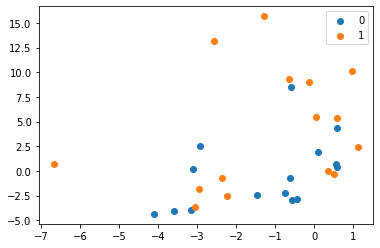

In [87]:
scat(X_train,y_train,tree)

#### 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。

深さ2とは空間の分割を2回行うことを指します。

《ヒント》

各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

In [ ]:
from collections import Counter

In [ ]:
class ScratchDecesionTreeClassifierDepthInf():
    def __init__(self, verbose=True,max_depth=2):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.left = None      # 左側に分岐した子ノード
        self.right = None     # 右側に分岐した子ノード
        self.feature = None   # 分岐条件の特徴量
        self.threshold = None     # 分岐条件のしきい値
        self.label = None     # 自身の予測ラベル
        self.info_ig = 0      # 自身の情報ゲイン
        self.max_depth = max_depth
        self.depth = 0
        
    def _ai(self,X,y):
        clas = np.unique(y)
        gini =1
        for c in clas:
#         idx_0 = np.where(y==0)
#         idx_1 = np.where(y==1)
#         X0 = (X[idx_0].shape[0]/(X.shape[0]))**2
#         X1 = (X[idx_1].shape[0]/(X.shape[0]))**2

            gini -= (len(y[y==c]) / len(y)) ** 2
        return gini    
    
    def _ig(self,X,y):
        n_feature = X.shape[1]
        node_list=[]
        threshold_list=[]
        feature_list=[]
        for f in range(n_feature):
            threshold = X[:,f]
            for x,i in enumerate(threshold):
                node_0 = np.where(X[:,f]>=i)
                node_1 = np.where(X[:,f]<i)
                if len(node_1[0]) == 0:
                    threshold_list.append(i)
                    feature_list.append(f)
                    node_list.append(0)
                    continue
                else:

                    left = self._ai(X[node_0],y[node_0])

                    right = self._ai(X[node_1],y[node_1])

                    ig = self.gini - (X[node_0].shape[0]*left /X.shape[0]) - (X[node_1].shape[0]*right /X.shape[0])
                    node_list.append(ig)
                    threshold_list.append(i)
                    feature_list.append(f)

        self.zip_list = zip(node_list,threshold_list,feature_list)
#         print("--------------------------------------------------")
#         print("node_list",node_list,"\n","threshold_list",threshold_list)
#         print("--------------------------------------------------")
        return list(max(self.zip_list))

        
    def updata(self, X, y):
#         print("X",X)
#         print("y",y)
        print(np.unique(y))
    
        # ラベルの各クラスの数をdict型で返す。　把握しやすい
        class_counts = Counter(y)
        #多数決をとって多い方のラベルを保存
        self.label = max(class_counts, key=class_counts.get)
        print("class",class_counts)  

        
        #ユニークか判定 ユニークだった場合　その値をlabelに更新　その後リターン
        if len(np.unique(y)) == 1:
            self.label = np.unique(y)[0]
            print("label",self.label)
            print("ーーーーーーーーーーーー8ーーーーーーーーーー")
            return
        
        #ジニ不純度の計算
        self.gini = self._ai(X,y)  

        #情報利得の計算
        y_hat = self._ig(X,y)
        print("threshold",y_hat[1])
        
        #各値を代入とともに保存
        self.info_ig = y_hat[0] #infomation_gainの保存
        self.threshold = y_hat[1] #thresholdの保存
        self.feature = y_hat[2] #列数の保存⇨非常に大事

        #左のリーフノードを探す　回帰にてユニーク値が一つになるまで
        left_idx = np.where(X[:,self.feature]>=self.threshold)
        self.left = Node()
        self.left.updata(X[left_idx],y[left_idx])
        print("left_end")
        
        #右のリーフノードを探す　回帰にてユニーク値が一つになるまで
        right_idx = np.where(X[:,self.feature]<self.threshold)
        self.right = Node()
        self.right.updata(X[right_idx],y[right_idx])        
        print("right_end")

#             if 0 in y[self.left]  and 1 in y[self.left]:
#                 if 0 in y[self.right]:
#                     self.yl = 1
#                     self.yr= 0
#                 else:
#                     self.yl = 0
#                     self.yr = 1
#             else:
#                 if 0 in y[self.left]:
#                     self.yl = 0
#                     self.yr= 1
#                 else:
#                     self.yl = 1
#                     self.yr = 0

        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print(self.threshold)
            print("------------------------------------------------------------------------")

    def decision(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        #self.y_hat = np.where(X[:,0]>=self.threshold,self.yl,self.yr)
        
        if self.threshold != None:

            if X[self.feature] >= self.threshold:
                return self.left.decision(X)
            if X[self.feature] < self.threshold:
                return self.right.decision(X)
        else:
            print(self.label)
            return self.label
        
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        #self.y_hat = np.where(X[:,0]>=self.threshold,self.yl,self.yr)
        pred_list = []
        for i in X:
            print(i)
            pred_list.append(self.decision(i))
        return pred_list
                        

In [ ]:
tree = ScratchDecesionTreeClassifierDepthInf()
tree.updata(X_train,y_train)
y_tree= tree.predict(X_test)
y_tree

In [ ]:
accuracy_score(y_tree,y_test)

In [ ]:
precision_score(y_tree,y_test)

In [ ]:
recall_score(y_tree,y_test)

In [ ]:
f1_score(y_tree,y_test)

#### 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。

任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

In [ ]:
X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
#y = y[:,np.newaxis]
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [ ]:
y_train[y_train==0],X_train[y_train==1]

In [ ]:
def gini(y):
    gini = 1
    label = np.unique(y)
    for i in label:
        gini -= (len(y[y==i]) / len(y))**2
    return gini

In [88]:
gini(y_train)

0.5

In [89]:
treshold = 0.96765

In [90]:
y_train[X_train[:,0] >= threshold]

array([1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [91]:
X_train[:,0]

array([-2.9452  , -2.353   , -0.12243 ,  0.10645 ,  0.057313, -0.65259 ,
       -6.6797  ,  0.58619 ,  1.1319  , -0.61251 , -2.9362  , -3.1625  ,
        0.6017  , -0.57242 , -3.0603  , -0.60216 ,  0.50214 , -1.4621  ,
       -2.234   , -3.1108  ,  0.59912 ,  0.96765 ,  0.56421 , -1.281   ,
        0.35084 , -4.1013  , -0.73535 , -2.5677  , -3.5944  , -0.44699 ])

In [92]:
def info_gain(X,y):
    feature = X.shape[1]
    ig_list = []
    feature_list = []
    threshold_list = []
    for f in range(feature):
        threshold = X[:,f]
        for thr in threshold:
            left = gini(y[X[:,f] >= thr])
            right = gini(y[X[:,f] < thr])

            ig = gini(y) - (len(y[X[:,f] >= thr])/len(y))*left - (len(y[X[:,f] < thr])/len(y))*right
            ig_list.append(ig)
            feature_list.append(f)
            threshold_list.append(thr)
            ig_max = max(zip(ig_list, feature_list, threshold_list))
    return ig_max

In [93]:
info_gain(X_train,y_train)

(0.10227272727272729, 1, 5.3524)

In [102]:
import scipy.stats as stats
class ScratchDecesionTreeClassifierDepthInf():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
        self.depth = 0
        self.left = None
        self.right = None
        self.feature = None
        self.threshold = None
        self.label = None
        self.ig = None
        
    def _gini(self,y):
        gini = 1
        label = np.unique(y)
        for i in label:
            gini -= (len(y[y==i]) / len(y))**2
        return gini

    def _info_gain(self,X,y):
        feature = X.shape[1]
        ig_list = []
        feature_list = []
        threshold_list = []
        for f in range(feature):
            threshold = X[:,f]
            for thr in threshold:
                left = self._gini(y[X[:,f] >= thr])
                right = self._gini(y[X[:,f] < thr])
                ig = self._gini(y) - (len(y[X[:,f] >= thr])/len(y))*left - (len(y[X[:,f] < thr])/len(y))*right
                ig_list.append(ig)
                feature_list.append(f)
                threshold_list.append(thr)
                ig_max = max(zip(ig_list, feature_list, threshold_list))
        return ig_max
    
#     def restriction(self,depth):
#         self.depth = depth
#         return self.depth
    
    def fit(self,X,y):
        self._split(X,y,self.depth)

    def _split(self,X,y,depth):
        self.depth = depth
        if  len(np.unique(y)) == 1:
            self.label = np.unique(y)[0]
            return 
        
        self.label = stats.mode(y)[0][0]
        
        gain = self._info_gain(X,y)
        self.ig = gain[0]
        self.feature = gain[1]
        self.threshold = gain[2]
        
        print("----------------------------------------------")
        print("ノードの深さ{}".format(self.depth))
        print(self.depth)
        if self.max_depth == self.depth:
            return
        
        self.left = ScratchDecesionTreeClassifierDepthInf(self.max_depth)
        self.left._split(X[X[:,self.feature] >= self.threshold],
                      y[X[:,self.feature] >= self.threshold],self.depth+1)

        self.right = ScratchDecesionTreeClassifierDepthInf(self.max_depth)
        self.right._split(X[X[:,self.feature] < self.threshold],
                       y[X[:,self.feature] < self.threshold],self.depth+1)

                
    def _judg(self,X):
        print("探索中----　深さ；{}".format(self.depth))
        if self.threshold != None and self.max_depth > self.depth :
            if X[self.feature] >= self.threshold:
                print("--------------left_label----------")
                print("X >= threshold : {}".format(self.threshold))
                return self.left._judg(X)
            else:
                print("--------------right_label----------")
                print("X < threshold : {}".format(self.threshold))
                return self.right._judg(X)
        else:
            print()
            print("発見！ラベル：{}".format(self.label))
            print()
            return self.label
    
    def predict(self,X):
        pred_list = []
        for i in X:
            pred = self._judg(i)
            pred_list.append(pred)
        return pred_list

In [103]:
stats.mode(y)

ModeResult(mode=array([0]), count=array([20]))

In [107]:
sdt = ScratchDecesionTreeClassifierDepthInf(max_depth=2)
sdt.fit(X_train,y_train)

----------------------------------------------
ノードの深さ0
0
----------------------------------------------
ノードの深さ1
1
----------------------------------------------
ノードの深さ2
2
----------------------------------------------
ノードの深さ1
1
----------------------------------------------
ノードの深さ2
2


In [109]:
y_predict =  sdt.predict(X_test)
y_predict

探索中----　深さ；0
--------------left_label----------
X >= threshold : 5.3524
探索中----　深さ；1
--------------right_label----------
X < threshold : 9.0162
探索中----　深さ；2

発見！ラベル：1

探索中----　深さ；0
--------------right_label----------
X < threshold : 5.3524
探索中----　深さ；1
--------------left_label----------
X >= threshold : -3.6461
探索中----　深さ；2

発見！ラベル：0

探索中----　深さ；0
--------------right_label----------
X < threshold : 5.3524
探索中----　深さ；1
--------------left_label----------
X >= threshold : -3.6461
探索中----　深さ；2

発見！ラベル：0

探索中----　深さ；0
--------------right_label----------
X < threshold : 5.3524
探索中----　深さ；1
--------------left_label----------
X >= threshold : -3.6461
探索中----　深さ；2

発見！ラベル：0

探索中----　深さ；0
--------------right_label----------
X < threshold : 5.3524
探索中----　深さ；1
--------------left_label----------
X >= threshold : -3.6461
探索中----　深さ；2

発見！ラベル：0

探索中----　深さ；0
--------------right_label----------
X < threshold : 5.3524
探索中----　深さ；1
--------------left_label----------
X >= threshold : -3.6461
探索中----　深さ；

[1, 0, 0, 0, 0, 0, 0, 0, 1, 1]

In [110]:
accuracy_score(y_predict,y_test)

0.6